In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import random
import cmath

from scipy.stats import norm
import matplotlib.mlab as mlab

# notes on comments: Q - Questions, A - Attention (to do, to pay attention to)

np.random.seed(8)

In [2]:
# BASIC FUNCTIONS

# lif neuron with noise (Gaussian)
def LIF_step_noise(voltage, tau, current, dt, threshold, voltage_rest, resistance, std_noise):
    if voltage < threshold:
        return (- voltage + current * resistance + voltage_rest) * dt / tau + voltage + np.random.normal(0, std_noise, 1)
    else:
        return voltage_rest + np.random.normal(0, std_noise, 1)
    
# grad decent (real numbers), quadratic error function, target function: product
def weight_update(weights, x, y, mu): 
    # mu learning rate
    return weights + 2 * mu * (y - np.dot(weights, x)) * x

# grad decent (real numbers), quadratic error function, target function: sum
def delay_update_2(delays, x, y, mu): 
    # shape of delays: (neurons,)
    # mu learning rate
    return delays + 2 * mu * (y - (x + delays)) #ATTENTION: Y is a scalar, x and delays are vectors (but it works)!!!

# (complex) phase
def convert_phase(T, t):
    return math.pi * t / (T * 2) 

# time from (complex) phase
def convert_phase_back(T, phi):
    return phi * 2 * t_max / math.pi

# complex exponential for arrays
def convert_exp(array): 
    res = np.zeros(len(array), dtype=np.complex_)
    for a in range(len(array)):
        res[a] = cmath.exp(array[a])
    return res

In [3]:
# PARAMETER SETTINGS

#lif neuron
dt = 0.001
tau = 5 
threshold = -40 
voltage_rest = -70
resistance = 1

#data set
neurons = 10
t_max = 10

learning_rate = 0.1

In [4]:
# DATA SET X (BASIC PATTERN ASSIGNED RANDOMLY)
# creates one 'basic pattern' and adds some noise on top (to get train/test data)

# A: Gaussian: long tails (overlap intervals, neg weights possible for high std), by 'chance' two spikes at the same time

def data(neurons, t_max, size, std_jitter, std_p):
    # neurons: number of neurons
    # size: size of the whole data set
    # t_max: length of one time interval
    # std_jitter / std_p: noise parameters 
    collect_delays = np.zeros((neurons, size))
    collect_weights = np.zeros((neurons, size))
    X_delays = np.random.uniform(0, t_max, neurons) #arbitrary 'spike pattern' - 'basis'
    X_weights = np.ones(neurons) #'weight of input' (equals the probability of the neurons to 'add their spike pattern to input LIF')
    
    for a in range(size):
        jitter = np.random.normal(0, std_jitter, neurons)
        jitter_2 = np.random.normal(0, std_p, neurons)
        collect_delays[:, a] = X_delays + jitter
        collect_weights[:, a] = X_weights + jitter_2
        collect_weights[:, a] = [0 if i < 0 else i for i in collect_weights[:, a]]
        collect_delays[:, a] = [0 if i < 0 else i for i in collect_delays[:, a]]
        collect_delays[:, a] = [10 if i > 10 else i for i in collect_delays[:, a]]
        
    return collect_delays, collect_weights, X_delays, X_weights
       
# DESIRED OUTPUT O

Y_delay = 12 #desired postsyn spike time, arbitrarily set to a value greater than t_max
Y_weight = abs(threshold - voltage_rest)

In [5]:
# MODULE 2 - GRADIENT DESCENT

# module_2: grad decent one training example
# module_2_2: grad decent with different training examples every step ('noisy'), 'mini-batch'

# Q: 'noisy': no noise on Y, learning rate changing dynamically

def module_2 (X_pattern, X_weight, Y, Y_weight, learning_rate, iterations, neurons):
    d_evolution = np.zeros((neurons, iterations, 2))
    for a in range(iterations):
        if a > 0:
            #learning rate needs to be adapted to number of neurons (for weights), otherwise no convergence (e.g. oscillations for too high rates)
            d_evolution[:, a, 0] = delay_update_2(d_evolution[:, a - 1, 0], X_pattern, Y, learning_rate)
            d_evolution[:, a, 1] = weight_update(d_evolution[:, a - 1, 1], X_weight, Y_weight, learning_rate / neurons)
    return d_evolution

def module_2_2 (X_pattern, X_weight, Y, Y_weight, learning_rate, iterations, neurons):
    d_evolution = np.zeros((neurons, iterations + 1, 2))
    for a in range(iterations + 1):
        if a > 0:
            d_evolution[:, a, 0] = delay_update_2(d_evolution[:, a - 1, 0], X_pattern[:, a], Y, learning_rate)
            d_evolution[:, a, 1] = weight_update(d_evolution[:, a - 1, 1], X_weight[:, a], Y_weight, learning_rate / neurons)
    return d_evolution

In [6]:
# TEST MODULE 2 - rerun it for histogram values - only noise on the presynaptic weights

size_dataset_2 = 400 # for computing histogram input currents only
training = 0.2 # train also on 80 examples only
iterations = int(size_dataset_2 * training) - 1

std_weight = [0.025, 0.05, 0.1, 0.25, 0.5]

delays = np.zeros((int(len(std_weight)), neurons, size_dataset_2))
weights = np.zeros((int(len(std_weight)), neurons, size_dataset_2))
basic_delay = np.zeros((int(len(std_weight)), neurons)) 
basic_weight = np.zeros((int(len(std_weight)), neurons)) 

result = np.zeros((int(len(std_weight)), neurons, 2))

for a in range(len(std_weight)):
    delays[a, :, :], weights[a, :, :], basic_delay[a, :], basic_weight[a, :] = data(neurons, t_max, size_dataset_2, 0.0, std_weight[a])
    result[a, :, :] = module_2_2(delays[a, :, :], weights[a, :, :], Y_delay, Y_weight, learning_rate, iterations, neurons)[:, iterations, :]

In [7]:
# VALUES HISTOGRAM

# A: for histogram only: NO NOISE ON THE SPIKE TIMES, NO NOISE ON MEMBRANE POTENTIAL
# A: decay parameter = t_max (now) / 2 (independence assumption)

# Q: time resolution of the simulation
# Q: scaling of the weights (to compensate noise e.g.)

time_max = 50 #max time of the simulation

count = np.zeros((int(len(std_weight)), 1))

collect_max_current = np.zeros((int(len(std_weight)), 320))
collect_max_voltage = np.zeros((int(len(std_weight)), 320))
                               
for b in range(len(std_weight)):
    count_ = 0
    for l in range(320):
        
        X = delays[b, :, (iterations + l)] #basic_delay
        X_w = weights[b, :, (iterations + l)] #basic_weight
        
        #membrane voltage postsyn
        voltage_steps = np.zeros((int(time_max/dt), 1))

        #input current (determined by spikes and respective delays) - postsyn.
        spikes_ = np.zeros(int(time_max / dt))
  
        #times of spikes postsyn, using result grad decent mini-batch
        times = X + result[b, :, 0]
        times_sorted = np.sort(times)
     
        #round spike times with a precision of 3 decimal numbers (corresponds to a resolution of 0.001)
        #necessary to clearly define the input current
        times_rounded = np.round_(times_sorted, decimals = 3) 
  
        #weights, using result grad decent mini-batch
        weights_ = result[b, :, 1] * 1.1

        #input current post
        for a in range(neurons):
            if spikes_[int(times_rounded[a] / dt)] == 0: 
                spikes_[int(times_rounded[a] / dt)] = weights_[a] * tau / dt * X_w[a]
            else: 
                spikes_[int(times_rounded[a] / dt)] = spikes_[int(times_rounded[a] / dt)] + weights_[a] * tau / dt * X_w[a]

        collect_max_current[b, l] = np.max(spikes_)

        #membrane potential
        for k in range(int(time_max / dt)):
            if k ==0:
                voltage_steps[k, 0] = voltage_rest

            if k > 0:
                voltage_steps[k, 0] = LIF_step_noise(voltage_steps[k - 1, 0], tau, spikes_[k], dt, threshold, voltage_rest, resistance, 0)

        if np.max(voltage_steps[:, 0]) > threshold: count_ = count_ + 1
        collect_max_voltage[b, l] = np.max(voltage_steps[:, 0])
    count[b] = count_

std weight 0.025, mu 29.925, std 0.234, count 320.000
std weight 0.050, mu 30.125, std 0.471, count 320.000
std weight 0.100, mu 29.869, std 0.954, count 319.000
std weight 0.250, mu 29.714, std 2.367, count 267.000
std weight 0.500, mu 30.626, std 4.689, count 249.000


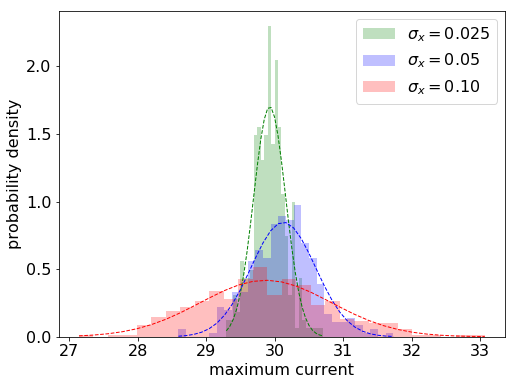

In [8]:
# HISTOGRAM

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(len(std_weight)):
    scaled_max_current = collect_max_current[i, :] * dt / tau / 1.1
    if i == 0:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='green', alpha=0.25, label = r'$\sigma_x = %.3f$' % std_weight[i])
        mu, std = norm.fit(scaled_max_current)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'g--', linewidth=1)
    if i == 1:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='blue', alpha=0.25, label = r'$\sigma_x = %.2f$' % std_weight[i])
        mu, std = norm.fit(scaled_max_current)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'b--', linewidth=1)
    if i == 2:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='red', alpha=0.25, label = r'$\sigma_x = %.2f$' % std_weight[i])
        mu, std = norm.fit(scaled_max_current)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'r--', linewidth=1)
    else:
        mu, std = norm.fit(scaled_max_current)
    print('std weight %.3f, mu %.3f, std %.3f, count %.3f' % (std_weight[i], mu, std, count[i]))

plt.legend()
plt.xlabel('maximum current')
plt.ylabel('probability density')
#plt.savefig('histogram_currents_noise_weights_2.pdf')
plt.show()

std weight 0.025, mu -37.082, std 0.258, count 320.000
std weight 0.050, mu -36.863, std 0.518, count 320.000
std weight 0.100, mu -37.144, std 1.050, count 319.000
std weight 0.250, mu -37.314, std 2.603, count 267.000
std weight 0.500, mu -36.312, std 5.157, count 249.000


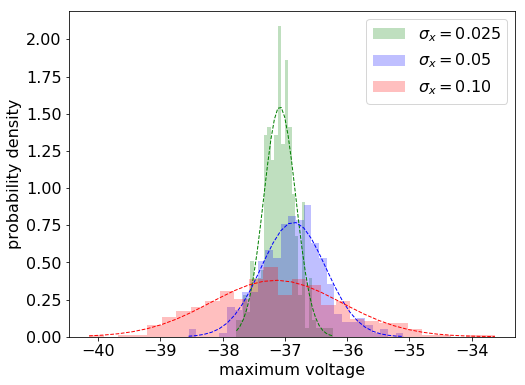

In [9]:
# HISTOGRAM 2 

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(len(std_weight)):
    scaled_max_voltage = collect_max_voltage[i, :]
    if i == 0:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='green', alpha=0.25, label = r'$\sigma_x = %.3f$' % std_weight[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'g--', linewidth=1)
    if i == 1:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='blue', alpha=0.25, label = r'$\sigma_x = %.2f$' % std_weight[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'b--', linewidth=1)
    if i == 2:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='red', alpha=0.25, label = r'$\sigma_x = %.2f$' % std_weight[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'r--', linewidth=1)
    else:
        mu, std = norm.fit(scaled_max_voltage)
    print('std weight %.3f, mu %.3f, std %.3f, count %.3f' % (std_weight[i], mu, std, count[i, 0]))

plt.legend()
plt.xlabel('maximum voltage')
plt.ylabel('probability density')
#plt.savefig('histogram_potentials_noise_weights_2.pdf')
plt.show()

In [10]:
# TEST MODULE 2 - rerun it for histogram values 2 - noise on weights and delays

size_dataset_2 = 400 # for computing histogram input currents only
training = 0.2 # train also on 80 examples only
iterations = int(size_dataset_2 * training) - 1

std_jitter = [0.025, 0.05, 0.1, 0.25, 0.5]

delays = np.zeros((int(len(std_weight)), neurons, size_dataset_2))
weights = np.zeros((int(len(std_weight)), neurons, size_dataset_2))
basic_delay = np.zeros((int(len(std_weight)), neurons)) 
basic_weight = np.zeros((int(len(std_weight)), neurons)) 

result = np.zeros((int(len(std_weight)), neurons, 2))

for a in range(len(std_weight)):
    delays[a, :, :], weights[a, :, :], basic_delay[a, :], basic_weight[a, :] = data(neurons, t_max, size_dataset_2, std_jitter[a], 0.025)
    result[a, :, :] = module_2_2(delays[a, :, :], weights[a, :, :], Y_delay, Y_weight, learning_rate, iterations, neurons)[:, iterations, :]

In [11]:
# VALUES HISTOGRAM

# A: for histogram only: NO NOISE ON THE SPIKE TIMES, NO NOISE ON MEMBRANE POTENTIAL
# A: decay parameter = t_max (now) / 2 (independence assumption)

# Q: time resolution of the simulation
# Q: scaling of the weights (to compensate noise e.g.)

time_max = 50 #max time of the simulation

count = np.zeros((int(len(std_jitter)), 1))

collect_max_current = np.zeros((int(len(std_jitter)), 320))
collect_max_voltage = np.zeros((int(len(std_jitter)), 320))
                               
for b in range(len(std_jitter)):
    count_ = 0
    for l in range(320):
        
        X = delays[b, :, (iterations + l)] #basic_delay
        X_w = weights[b, :, (iterations + l)] #basic_weight
        
        #membrane voltage postsyn
        voltage_steps = np.zeros((int(time_max/dt), 1))

        #input current (determined by spikes and respective delays) - postsyn.
        spikes_ = np.zeros(int(time_max / dt))
  
        #times of spikes postsyn, using result grad decent mini-batch
        times = X + result[b, :, 0]
        times_sorted = np.sort(times)
     
        #round spike times with a precision of 3 decimal numbers (corresponds to a resolution of 0.001)
        #necessary to clearly define the input current
        times_rounded = np.round_(times_sorted, decimals = 3) 
  
        #weights, using result grad decent mini-batch
        weights_ = result[b, :, 1] * 1.1

        #input current post
        for a in range(neurons):
            if spikes_[int(times_rounded[a] / dt)] == 0: 
                spikes_[int(times_rounded[a] / dt)] = weights_[a] * tau / dt * X_w[a]
            else: 
                spikes_[int(times_rounded[a] / dt)] = spikes_[int(times_rounded[a] / dt)] + weights_[a] * tau / dt * X_w[a]

        collect_max_current[b, l] = np.max(spikes_)

        #membrane potential
        for k in range(int(time_max / dt)):
            if k ==0:
                voltage_steps[k, 0] = voltage_rest

            if k > 0:
                voltage_steps[k, 0] = LIF_step_noise(voltage_steps[k - 1, 0], tau, spikes_[k], dt, threshold, voltage_rest, resistance, 0)

        if np.max(voltage_steps[:, 0]) > threshold: count_ = count_ + 1
        collect_max_voltage[b, l] = np.max(voltage_steps[:, 0])
    count[b] = count_

std jitter 0.025, max current 9.180
std jitter 0.050, max current 8.744
std jitter 0.100, max current 9.058
std jitter 0.250, max current 6.200
std jitter 0.500, max current 6.281


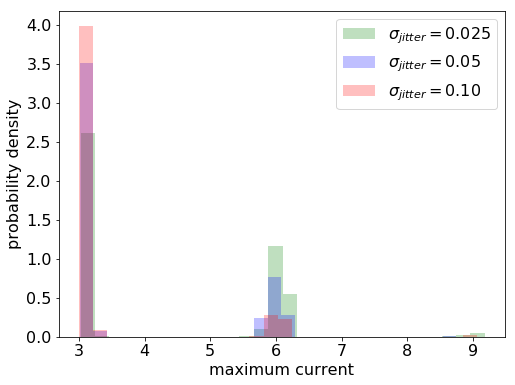

In [12]:
# HISTOGRAM 3

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(5):
    scaled_max_current = collect_max_current[i, :] * dt / tau / 1.1
    if i == 0:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='green', alpha=0.25, label = r'$\sigma_{jitter} = %.3f$' % std_weight[i])
    if i == 1:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='blue', alpha=0.25, label = r'$\sigma_{jitter} = %.2f$' % std_weight[i])
    if i == 2:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='red', alpha=0.25, label = r'$\sigma_{jitter} = %.2f$' % std_weight[i])
    print('std jitter %.3f, max current %.3f' % (std_jitter[i], np.max(scaled_max_current)))
    
plt.legend()
plt.xlabel('maximum current')
plt.ylabel('probability density')
#plt.savefig('histogram_currents_noise_weights_jitter_2.pdf')
plt.show()

std jitter 0.025, mu -37.221, std 0.235, count 320.000
std jitter 0.050, mu -37.541, std 0.293, count 320.000
std jitter 0.100, mu -38.076, std 0.401, count 320.000


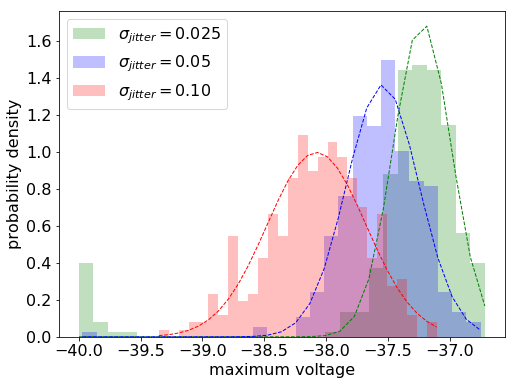

In [13]:
# HISTOGRAM 4

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(3):
    scaled_max_voltage = collect_max_voltage[i, :]
    if i == 0:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='green', alpha=0.25, label = r'$\sigma_{jitter} = %.3f$' % std_weight[i])
        # filter small values (as they do not 'belong' to the normal distribution)
        scaled_max_voltage = [0 if i < -39.5 else i for i in scaled_max_voltage]
        scaled_max_voltage_2 = []
        for j in range(np.count_nonzero(scaled_max_voltage)):
            scaled_max_voltage_2.append(scaled_max_voltage[np.nonzero(scaled_max_voltage)[0][j]])
        mu, std = norm.fit(scaled_max_voltage_2)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'g--', linewidth=1)
    if i == 1:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='blue', alpha=0.25, label = r'$\sigma_{jitter} = %.2f$' % std_weight[i])
        scaled_max_voltage = [0 if i < -39.5 else i for i in scaled_max_voltage]
        scaled_max_voltage_2 = []
        for j in range(np.count_nonzero(scaled_max_voltage)):
            scaled_max_voltage_2.append(scaled_max_voltage[np.nonzero(scaled_max_voltage)[0][j]])
        mu, std = norm.fit(scaled_max_voltage_2)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'b--', linewidth=1)
    if i == 2:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='red', alpha=0.25, label = r'$\sigma_{jitter} = %.2f$' % std_weight[i])
        scaled_max_voltage = [0 if i < -39.5 else i for i in scaled_max_voltage]
        scaled_max_voltage_2 = []
        for j in range(np.count_nonzero(scaled_max_voltage)):
            scaled_max_voltage_2.append(scaled_max_voltage[np.nonzero(scaled_max_voltage)[0][j]])
        mu, std = norm.fit(scaled_max_voltage_2)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'r--', linewidth=1)
    print('std jitter %.3f, mu %.3f, std %.3f, count %.3f' % (std_jitter[i], mu, std, count[i, 0]))

plt.legend()
plt.xlabel('maximum voltage')
plt.ylabel('probability density')
#plt.savefig('histogram_potentials_noise_weights_jitter_3.pdf')
plt.show()

std jitter 0.250, mu -39.612, std 0.868, count 225.000
std jitter 0.500, mu -41.058, std 1.197, count 53.000


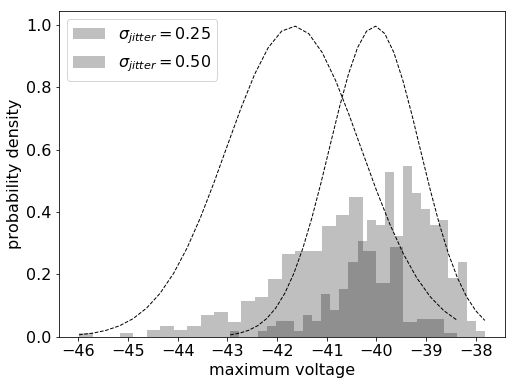

In [24]:
# HISTOGRAM 4

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(len(std_weight)):
    if i > 2:
        scaled_max_voltage = collect_max_voltage[i, :]
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='black', alpha=0.25, label = r'$\sigma_{jitter} = %.2f$' % std_weight[i])
        mu, std = norm.fit(scaled_max_voltage)
        plt.plot(bins, y, 'k--', linewidth=1)
        print('std jitter %.3f, mu %.3f, std %.3f, count %.3f' % (std_jitter[i], mu, std, count[i, 0]))

plt.legend()
plt.xlabel('maximum voltage')
plt.ylabel('probability density')
#plt.savefig('histogram_potentials_noise_weights_jitter_3.pdf')
plt.show()

In [14]:
# TEST MODULE 2 - rerun it for histogram values 3

size_dataset_2 = 400 # for computing histogram input currents only
training = 0.2 # train also on 80 examples only
iterations = int(size_dataset_2 * training) - 1

delays_noise_membrane, weights_noise_membrane, basic_delay_, basic_weight_ = data(neurons, t_max, size_dataset_2, 0.025, 0.025)
result_noise_membrane = module_2_2(delays_noise_membrane, weights_noise_membrane, Y_delay, Y_weight, learning_rate, iterations, neurons)

In [15]:
# VALUES HISTOGRAM

# A: for histogram only: NO NOISE ON THE SPIKE TIMES, NO NOISE ON MEMBRANE POTENTIAL
# A: decay parameter = t_max (now) / 2 (independence assumption)

# Q: time resolution of the simulation
# Q: scaling of the weights (to compensate noise e.g.)

time_max = 50 #max time of the simulation

std_noise_membrane = [0, 0.01, 0.1, 0.25, 0.5, 0.75, 1.5]

count = np.zeros((int(len(std_noise_membrane)), 1))
print(np.shape(count))

collect_max_current = np.zeros((int(len(std_noise_membrane)), 320))
collect_max_voltage = np.zeros((int(len(std_noise_membrane)), 320))
                               
for b in range(len(std_noise_membrane)):
    count_ = 0
    for l in range(320):
        X = delays_noise_membrane[:, (iterations + l)] #basic_delay
        X_w = weights_noise_membrane[:, (iterations + l)] #basic_weight
        
        #membrane voltage postsyn
        voltage_steps = np.zeros((int(time_max/dt), 1))

        #input current (determined by spikes and respective delays) - postsyn.
        spikes_ = np.zeros(int(time_max / dt))
  
        #times of spikes postsyn, using result grad decent mini-batch
        times = X + result_noise_membrane[:, iterations, 0]
        times_sorted = np.sort(times)
     
        #round spike times with a precision of 3 decimal numbers (corresponds to a resolution of 0.001)
        #necessary to clearly define the input current
        times_rounded = np.round_(times_sorted, decimals = 3) 
  
        #weights, using result grad decent mini-batch
        weights_ = result_noise_membrane[:, iterations, 1] * 1.1

        #input current post
        for a in range(neurons):
            if spikes_[int(times_rounded[a] / dt)] == 0: 
                spikes_[int(times_rounded[a] / dt)] = weights_[a] * tau / dt * X_w[a]
            else: 
                spikes_[int(times_rounded[a] / dt)] = spikes_[int(times_rounded[a] / dt)] + weights_[a] * tau / dt * X_w[a]

        collect_max_current[b, l] = np.max(spikes_)

        #membrane potential
        for k in range(int(time_max / dt)):
            if k ==0:
                voltage_steps[k, 0] = voltage_rest

            if k > 0:
                voltage_steps[k, 0] = LIF_step_noise(voltage_steps[k - 1, 0], tau, spikes_[k], dt, threshold, voltage_rest, resistance, std_noise_membrane[b])

        if np.max(voltage_steps[:, 0]) > threshold: count_ = count_ + 1
        collect_max_voltage[b, l] = np.max(voltage_steps[:, 0])
    count[b, 0] = count_

(7, 1)


std membrane 0.000, max current 9.130
std membrane 0.010, max current 9.130
std membrane 0.100, max current 9.130
std membrane 0.250, max current 9.130
std membrane 0.500, max current 9.130
std membrane 0.750, max current 9.130
std membrane 1.500, max current 9.130


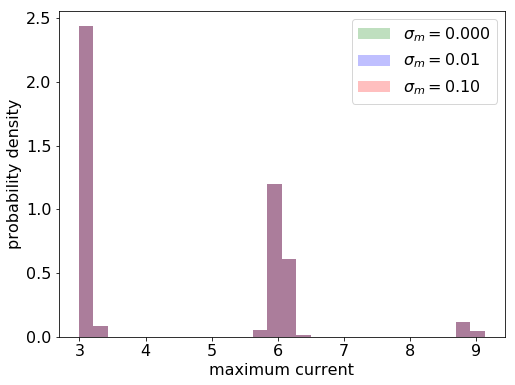

In [16]:
# HISTOGRAM 5

# expected to be the same as histogram 4, (0.025, 0.025) parameter noise, all the same as membrane potential has no influence on currents

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(len(std_noise_membrane)):
    scaled_max_current = collect_max_current[i, :] * dt / tau / 1.1
    if i == 0:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='green', alpha=0.25, label = r'$\sigma_{m} = %.3f$' % std_noise_membrane[i])
    if i == 1:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='blue', alpha=0.25, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
    if i == 2:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='red', alpha=0.25, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
    print('std membrane %.3f, max current %.3f' % (std_noise_membrane[i], np.max(scaled_max_current)))
    
plt.legend()
plt.xlabel('maximum current')
plt.ylabel('probability density')
#plt.savefig('histogram_currents_all_noise_2.pdf')
plt.show()

std membrane 0.000, mu -37.372, std 0.389, count 320.000
std membrane 0.010, mu -37.797, std 0.899, count 320.000
std membrane 0.100, mu -39.639, std 2.468, count 244.000
std membrane 0.250, mu -39.961, std 2.764, count 265.000
std membrane 0.500, mu -39.258, std 1.078, count 316.000
std membrane 0.750, mu -38.816, std 0.720, count 320.000
std membrane 1.500, mu -37.412, std 0.773, count 320.000


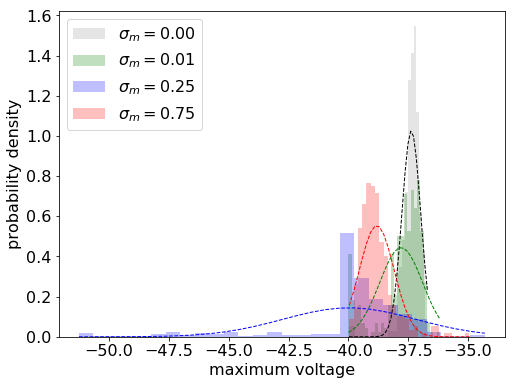

In [17]:
# HISTOGRAM 6

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(len(std_noise_membrane)):
    scaled_max_voltage = collect_max_voltage[i, :]
    if i == 0:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='black', alpha=0.1, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'k--', linewidth=1)
    if i == 1:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='green', alpha=0.25, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'g--', linewidth=1)
    if i == 3:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='blue', alpha=0.25, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'b--', linewidth=1)
    if i == 5:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='red', alpha=0.25, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'r--', linewidth=1)
    else:
        mu, std = norm.fit(scaled_max_voltage)
    print('std membrane %.3f, mu %.3f, std %.3f, count %.3f' % (std_noise_membrane[i], mu, std, count[i, 0]))

plt.legend()
plt.xlabel('maximum voltage')
plt.ylabel('probability density')
#plt.savefig('histogram_potentials_all_noise_2.pdf')
plt.show()

In [18]:
# VALUES HISTOGRAM

# A: for histogram only: NO NOISE ON THE SPIKE TIMES, NO NOISE ON MEMBRANE POTENTIAL
# A: decay parameter = t_max (now) / 2 (independence assumption)

# Q: time resolution of the simulation
# Q: scaling of the weights (to compensate noise e.g.)

time_max = 50 #max time of the simulation

std_noise_membrane = [0, 0.01, 0.1, 0.15, 0.2, 0.225, 0.25, 0.5, 0.75, 1.5]

count = np.zeros((int(len(std_noise_membrane)), 1))

collect_max_current = np.zeros((int(len(std_noise_membrane)), 320))
collect_max_voltage = np.zeros((int(len(std_noise_membrane)), 320))
                               
for b in range(len(std_noise_membrane)):
    count_ = 0
    for l in range(320):
        # arbitrary spike pattern 
        X = np.random.uniform(0, t_max, neurons) 
        jitter_2 = np.random.normal(0, 0.025, neurons)
        X_w = np.ones(neurons) + jitter_2 
        
        #membrane voltage postsyn
        voltage_steps = np.zeros((int(time_max/dt), 1))

        #input current (determined by spikes and respective delays) - postsyn.
        spikes_ = np.zeros(int(time_max / dt))
  
        #times of spikes postsyn, using result grad decent mini-batch
        times = X + result_noise_membrane[:, iterations, 0]
        times_sorted = np.sort(times)
     
        #round spike times with a precision of 3 decimal numbers (corresponds to a resolution of 0.001)
        #necessary to clearly define the input current
        times_rounded = np.round_(times_sorted, decimals = 3) 
  
        #weights, using result grad decent mini-batch
        weights_ = result_noise_membrane[:, iterations, 1] * 1.1

        #input current post
        for a in range(neurons):
            if spikes_[int(times_rounded[a] / dt)] == 0: 
                spikes_[int(times_rounded[a] / dt)] = weights_[a] * tau / dt * X_w[a]
            else: 
                spikes_[int(times_rounded[a] / dt)] = spikes_[int(times_rounded[a] / dt)] + weights_[a] * tau / dt * X_w[a]

        collect_max_current[b, l] = np.max(spikes_)

        #membrane potential

        for k in range(int(time_max / dt)):
                if k ==0:
                    voltage_steps[k, 0] = voltage_rest

                if k > 0:
                    voltage_steps[k, 0] = LIF_step_noise(voltage_steps[k - 1, 0], tau, spikes_[k], dt, threshold, voltage_rest, resistance, std_noise_membrane[b])

        if np.max(voltage_steps[:, 0]) > threshold: count_ = count_ + 1
        collect_max_voltage[b, l] = np.max(voltage_steps[:, 0])
    count[b, 0] = count_

std membrane 0.000, max current 5.931
std membrane 0.010, max current 3.251
std membrane 0.100, max current 3.270
std membrane 0.150, max current 5.905
std membrane 0.200, max current 6.085
std membrane 0.225, max current 5.919
std membrane 0.250, max current 6.169
std membrane 0.500, max current 6.226
std membrane 0.750, max current 3.235
std membrane 1.500, max current 6.167


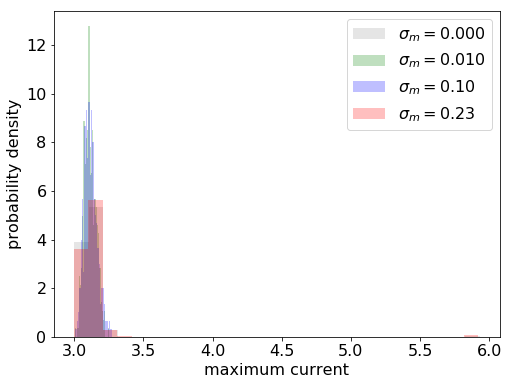

In [19]:
# HISTOGRAM 7

# expected to be the same as histogram 4, (0.025, 0.025) parameter noise, all the same as membrane potential has no influence on currents

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(len(std_noise_membrane)):
    scaled_max_current = collect_max_current[i, :] * dt / tau / 1.1
    if i == 0:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='black', alpha=0.1, label = r'$\sigma_{m} = %.3f$' % std_noise_membrane[i])
    if i == 1:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='green', alpha=0.25, label = r'$\sigma_{m} = %.3f$' % std_noise_membrane[i])
    if i == 2:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='blue', alpha=0.25, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
    if i == 5:
        n, bins, patches = plt.hist(scaled_max_current, 28, normed = 1, facecolor='red', alpha=0.25, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
    print('std membrane %.3f, max current %.3f' % (std_noise_membrane[i], np.max(scaled_max_current)))
    
plt.legend()
plt.xlabel('maximum current')
plt.ylabel('probability density')
#plt.savefig('histogram_currents_all_noise_random_2.pdf')
plt.show()

std membrane 0.000, mu -54.404, std 2.397, count 0.000
std membrane 0.010, mu -54.374, std 2.276, count 0.000
std membrane 0.100, mu -50.923, std 4.028, count 1.000
std membrane 0.150, mu -46.842, std 4.989, count 41.000
std membrane 0.200, mu -43.877, std 4.454, count 111.000
std membrane 0.225, mu -42.695, std 4.052, count 158.000
std membrane 0.250, mu -41.624, std 3.102, count 198.000
std membrane 0.500, mu -39.522, std 1.014, count 310.000
std membrane 0.750, mu -38.980, std 0.591, count 317.000
std membrane 1.500, mu -37.375, std 0.849, count 320.000


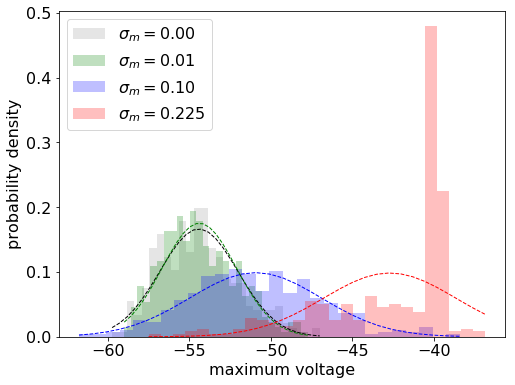

In [20]:
# HISTOGRAM 8

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

save_std = []
save_mu = []

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(len(std_noise_membrane)):
    scaled_max_voltage = collect_max_voltage[i, :]
    if i == 0:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='black', alpha=0.1, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'k--', linewidth=1)
    if i == 1:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='green', alpha=0.25, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'g--', linewidth=1)
    if i == 2:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='blue', alpha=0.25, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'b--', linewidth=1)
    if i == 5:
        n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='red', alpha=0.25, label = r'$\sigma_{m} = %.3f$' % std_noise_membrane[i])
        mu, std = norm.fit(scaled_max_voltage)
        y = mlab.normpdf(bins, mu, std)
        plt.plot(bins, y, 'r--', linewidth=1)
    else:
        mu, std = norm.fit(scaled_max_voltage)
    print('std membrane %.3f, mu %.3f, std %.3f, count %.3f' % (std_noise_membrane[i], mu, std, count[i, 0]))
    save_std.append(std)
    save_mu.append(mu)

plt.legend()
plt.xlabel('maximum voltage')
plt.ylabel('probability density')
#plt.savefig('histogram_potentials_all_noise_random_2.pdf')
plt.show()

In [21]:
# same test set always?! (or basic pattern)
# sufficient statistics
# purely random drawn sets to determine the 'threshold' spikes or noise is driving the statistics
# does the central limit theorem hold (the MEAN towards a normal distribution)

std membrane 0.000, mu -54.404, std 2.397, count 0.000
std membrane 0.010, mu -54.374, std 2.276, count 0.000
std membrane 0.100, mu -50.923, std 4.028, count 1.000
std membrane 0.150, mu -46.842, std 4.989, count 41.000
std membrane 0.200, mu -43.877, std 4.454, count 111.000
std membrane 0.225, mu -42.695, std 4.052, count 158.000
std membrane 0.250, mu -41.624, std 3.102, count 198.000
std membrane 0.500, mu -39.522, std 1.014, count 310.000
std membrane 0.750, mu -38.980, std 0.591, count 317.000
std membrane 1.500, mu -37.375, std 0.849, count 320.000


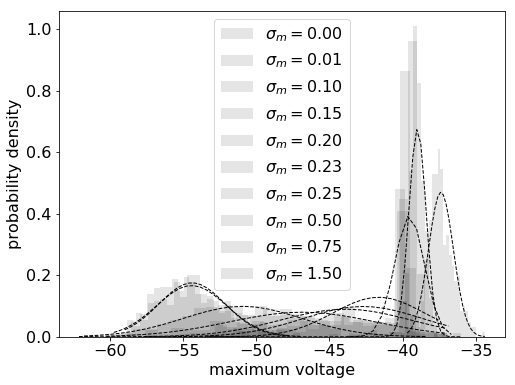

In [22]:
# HISTOGRAM 8

plt.figure(figsize = (8, 6))
plt.rcParams.update({'font.size': 16}) #change font size for figures

save_std = []
save_mu = []

# normalized = 1 -- divided by bin width such that the integral over the whole distribution equals 1

for i in range(len(std_noise_membrane)):
    scaled_max_voltage = collect_max_voltage[i, :]
    n, bins, patches = plt.hist(scaled_max_voltage, 28, normed = 1, facecolor='black', alpha=0.1, label = r'$\sigma_{m} = %.2f$' % std_noise_membrane[i])
    mu, std = norm.fit(scaled_max_voltage)
    y = mlab.normpdf(bins, mu, std)
    plt.plot(bins, y, 'k--', linewidth=1)

    print('std membrane %.3f, mu %.3f, std %.3f, count %.3f' % (std_noise_membrane[i], mu, std, count[i, 0]))

plt.legend()
plt.xlabel('maximum voltage')
plt.ylabel('probability density')
#plt.savefig('histogram_potentials_all_noise_random_2_all.pdf')
plt.show()